# Pip Installs

In [83]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile
!pip install alive-progress
!pip install --upgrade pytube

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [84]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import yt_dlp

# File Creation

### Creating File Paths

In [102]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Training_Wav_Files"
procesed_data_dir = os.path.abspath('') + "/Processed_Training_Wav_Files"

# YouTube Audio Download

In [103]:
def download_audio(url, starttime, endtime, output):
    # Convert start and end times to seconds
    hours, minutes, seconds = map(int, starttime.split(':'))
    start_time = hours * 3600 + minutes * 60 + seconds
    hours, minutes, seconds = map(int, endtime.split(':'))
    end_time = hours * 3600 + minutes * 60 + seconds
    
    """ 
    ydl_opts = {
        'format': 'bestaudio/best',  # Download the best audio format
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',  # Extract audio after download
            'preferredcodec': 'wav',  # Convert to wav format
        }],
        'noplaylist': True,  # Avoid downloading playlists, download a single video
        'quiet': False,  # Show output in the terminal
        'outtmpl': 'temp_audio.%(ext)s',  # Temporary output for the full audio
    }

    #Use yt-dlp to download the audio
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    """
    #Load the downloaded audio using pydub (assume the file was saved as temp_audio.wav)
    audio_file = audio.from_wav('temp_audio.wav')

    #Extract the desired clip (convert time to milliseconds)
    start_time_ms = start_time * 1000  # Convert start time from seconds to milliseconds
    end_time_ms = end_time * 1000      # Convert end time from seconds to milliseconds
    clip = audio_file[start_time_ms:end_time_ms]

    #Export the extracted clip as a new WAV file
    clip.export(output, format="wav")
    print(f"Audio clip saved to {output}")

    #Clean up the temporary file
    #os.remove('temp_audio.wav')

starttime = '2:49:59' 
endtime = '2:53:16'
name = 'dinaTitus40533Clip1'
download_audio(url='https://www.youtube.com/watch?v=EELSevWNbIk',
               starttime=starttime,
               endtime=endtime,
               output=f'{unprocessed_data_dir}/{name}.wav')

FileNotFoundError: [Errno 2] No such file or directory: 'temp_audio.wav'

Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [ ]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [86]:
for file in os.listdir(unprocessed_data_dir):
    if file != ".DS_Store":
        f_path = os.path.join(unprocessed_data_dir, file)
        arr, hz = librosa.load(f_path,sr = None)
        if hz != 16000:
            new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
            sf.write(f_path, new_f, 16000)

This is a test

In [6]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


## Remove the .DS_Store 
### This is a hiddent directory automatically created by Mac OS and causes errors

In [104]:
for folder in procesed_data_dir:
    path = os.path.join(folder, ".DS_Store")
    if folder == ".DS_Store":
        os.remove('.DS_Store')     

### Separates the files into 1 second intervals

In [ ]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{procesed_data_dir}/{congress_name}")
                new_audio.export(f"{procesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{procesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [95]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Training_Wav_Files/stephenCohen/stephenCohen40173Clip1_57.wav", sr = None)
print(b)

16000


## Feature Extraction

    The code below captures the spectral characteristics of the congress person speaking
    during the audio clip. This process mimics how people perceive and identify voices.
    The feature extraction below uses features which are derived from the Mel Scale and 
    cepstrum. These features are then used to train the model to identify patterns in 
    speaker voices. 

In [ ]:
num_data = 0

for foldr in os.listdir(procesed_data_dir):
    if foldr != ".DS_Store":
        num_data += len(os.listdir(f"{procesed_data_dir}/{foldr}"))

In [105]:
def feature_extract (data_dir):
    features = []
    labels = []
    with alive_bar(num_data,force_tty=True, title='Collecting Features', bar = 'scuba') as bar: 
        for foldr in os.listdir(data_dir):
            if foldr != ".DS_Store":
                for file in os.listdir(f"{data_dir}/{foldr}"):
                    arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                    mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                    mfccs = StandardScaler().fit_transform(mfccs)
                    features.append(mfccs.T)
                    labels.append(foldr)
                    bar()
                 
                
    return np.array(features), np.array(labels)           
features, labels = feature_extract(procesed_data_dir)

### Feature Visualization

In [106]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: mikeThompson, Features Shape: (32, 13)
[-3.3528137  -0.19482704  0.5605791   0.75114375  0.3998014   0.27799278
  0.20368043  0.5438508   0.14133175  0.44739565 -0.05309591  0.19697066
  0.07799034]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.4371326   0.46019027  0.4048246   0.22184645  0.57023907  0.24012643
  0.34591293  0.1501962   0.19041981  0.27497125  0.12990695  0.28289312
  0.1656054 ]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-2.807486    2.0600498  -0.08796098 -0.2440007   0.28515172  0.35909262
 -0.03842863 -0.4238753  -0.13312358  0.18792579  0.00875466  0.5027635
  0.33113727]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.3978493   0.9004972   0.24603708  0.43012097  0.30901477  0.29492196
  0.1808896   0.18083605  0.19038048  0.18384118  0.16422631  0.19734816
  0.11973543]
----------------------------------------
Label: mikeTh

### Training and splitting the data

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [108]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)

In [109]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)
print(y_train.shape)

(11176, 32, 13)
(11176,)


### Reshape for SVM since it takes 2D arrays

In [110]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

In [111]:
print(X_train_SVM.shape)
print(y_train.shape)
#print(X_train_SVM)
print(y_train)

(11176, 416)
(11176,)
['mikeKelly' 'jamesJordan' 'valHoyle' ... 'christopherSmith'
 'garretGraves' 'maríaSalazar']


### Trying the SVM approach

In [112]:
clm = SVC(kernel="linear", probability=True)

clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.5765926986399428


#### Shows the probability for each label for each data set

In [113]:
prob = clm.predict_proba(X_test_SVM)
for i, arr in enumerate(prob):
    prob[i] = np.round(arr * 100,3)

#### Prints all of the probabilities for each test data point

In [114]:
#np.set_printoptions(suppress=True)
#for i in prob:
#    print(i)

#### Prints the True Value, the predicted Value, and the certainty for each test data point

In [115]:
max = 0
for i, val in enumerate(prob):
    max = np.max(val)
    print(f"The True value is {y_test[i]}\n"
          f"The Predicted value is {y_predict[i]} and is {max} certain\n")
    

The True value is mikeKelly
The Predicted value is garretGraves and is 45.516 certain

The True value is addisonWilson
The Predicted value is addisonWilson and is 86.622 certain

The True value is johnLarson
The Predicted value is stephenCohen and is 50.58 certain

The True value is thomasMcClintock
The Predicted value is thomasMcClintock and is 14.636 certain

The True value is williamKeating
The Predicted value is williamKeating and is 55.412 certain

The True value is stephenCohen
The Predicted value is eleanorNorton and is 27.372 certain

The True value is stephenCohen
The Predicted value is garretGraves and is 25.771 certain

The True value is thomasKean
The Predicted value is thomasKean and is 49.64 certain

The True value is stephenCohen
The Predicted value is brianMast and is 36.196 certain

The True value is samuelGraves
The Predicted value is samuelGraves and is 27.208 certain

The True value is garretGraves
The Predicted value is richardLarsen and is 17.96 certain

The True 

In [116]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

mikeThompson 
	accuracy = 0.46153846153846156
	predict/real = 18/39
johnLarson 
	accuracy = 0.375
	predict/real = 21/56
dannyDavis 
	accuracy = 0.7346938775510204
	predict/real = 36/49
garretGraves 
	accuracy = 0.7662337662337663
	predict/real = 59/77
eleanorNorton 
	accuracy = 0.6666666666666666
	predict/real = 92/138
peteStauber 
	accuracy = 0.525
	predict/real = 21/40
earlBlumenauer 
	accuracy = 0.7045454545454546
	predict/real = 31/44
brandonWilliams 
	accuracy = 0.6052631578947368
	predict/real = 23/38
gregStanton 
	accuracy = 0.41304347826086957
	predict/real = 19/46
dinaTitus 
	accuracy = 0.7058823529411765
	predict/real = 24/34
jamesJordan 
	accuracy = 0.5483870967741935
	predict/real = 34/62
thomasKean 
	accuracy = 0.6853146853146853
	predict/real = 98/143
brianMast 
	accuracy = 0.6083916083916084
	predict/real = 87/143
aaronBean 
	accuracy = 0.41379310344827586
	predict/real = 12/29
valHoyle 
	accuracy = 0.45263157894736844
	predict/real = 43/95
kevinKiley 
	accuracy = 0.5666

Test Evaluation Accuracy: 0.5765926986399428


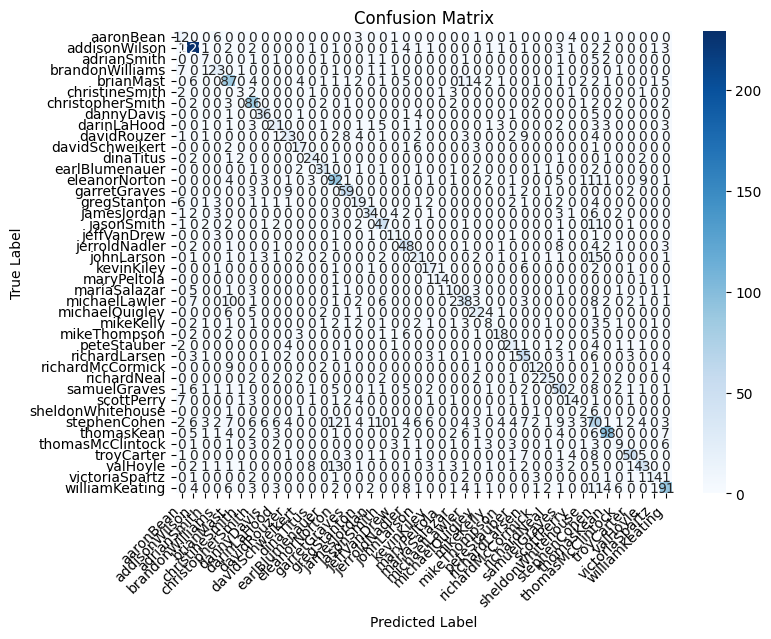

In [117]:
# Decode the labels back to original format
#y_test_decoded = label_encoder.inverse_transform(y_test)
#y_pred_decoded = label_encoder.inverse_transform(y_predict)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try RNN LSTM approach

### Training and testing

In [118]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.1343 - loss: 3.3334
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.3931 - loss: 2.1068
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5290 - loss: 1.5723
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6045 - loss: 1.3072
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.6410 - loss: 1.1654
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6769 - loss: 1.0324
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7164 - loss: 0.9238
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7407 - loss: 0.8411
Epoch 9/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7574 - loss: 0.7774
Epoch 10/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7721 - loss: 0.7192
Epoch 11/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7953 - loss: 0.6609
Epoch 12/20
350/350 ━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Test Evaluation Accuracy: 0.7247673586256264


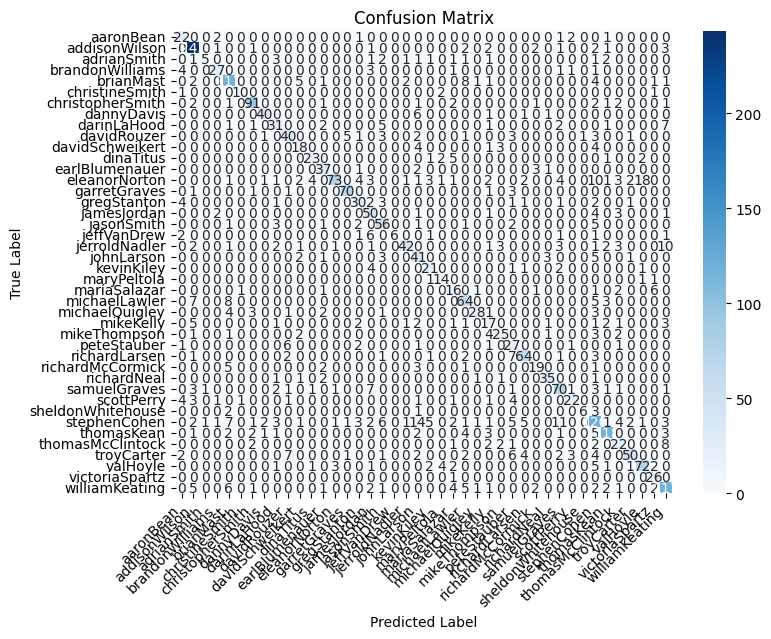

In [120]:
y_pred_probabilities = model.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try GRU RNN approach

In [122]:
num_speakers = len(next(os.walk(procesed_data_dir))[1])

np.random.seed(42)
tf.random.set_seed(42)

y_train_one_hot = to_categorical(y_train_rnn, num_classes=num_speakers)  # n = number of speakers
y_test_one_hot = to_categorical(y_test_rnn, num_classes=num_speakers)

gru = Sequential()
gru.add(GRU(128, return_sequences = False, input_shape = (32,13))) 
gru.add(BatchNormalization())
gru.add(Dropout(.5))
gru.add(Dense(num_speakers, activation = 'softmax'))
# Compile the model
gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
gru.summary()

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,842 (237.66 KB)

 Trainable params: 60,586 (236.66 KB)

 Non-trainable params: 256 (1.00 KB)

In [123]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = gru.fit(X_train_rnn, y_train_one_hot,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_test_rnn, y_test_one_hot),
                  callbacks=[early_stopping])

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.1550 - loss: 3.5115 - val_accuracy: 0.1127 - val_loss: 3.5629
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4488 - loss: 1.9462 - val_accuracy: 0.2462 - val_loss: 3.1880
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5099 - loss: 1.6819 - val_accuracy: 0.2577 - val_loss: 3.1288
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5572 - loss: 1.5306 - val_accuracy: 0.2971 - val_loss: 2.8072
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.5866 - loss: 1.4284 - val_accuracy: 0.5326 - val_loss: 1.5948
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.6096 - loss: 1.3273 - val_accuracy: 0.4531 - val_loss: 1.8762
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.6345 - loss: 1.2524 - val_accuracy: 0.5927 - val_loss: 1.3829
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.6574 - loss: 1.1568 - 

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
2794
Test Evaluation Accuracy: 0.7859699355762347


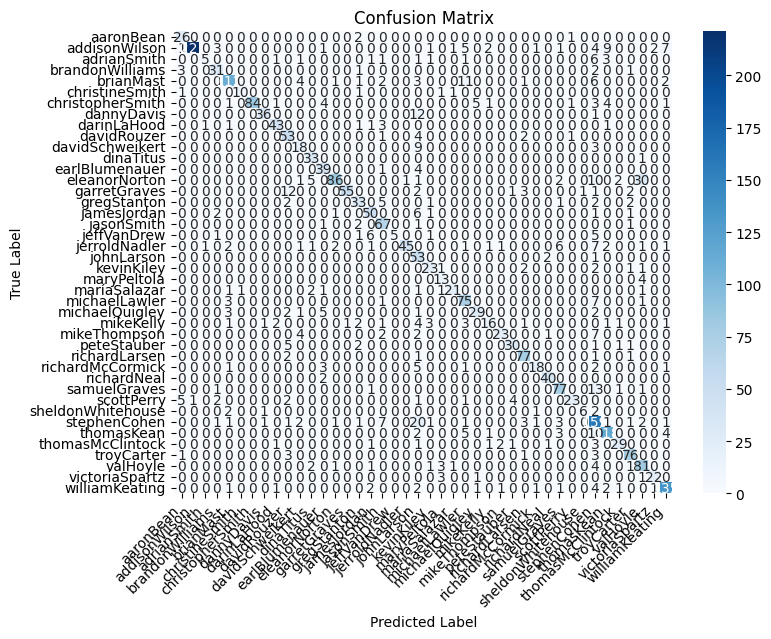

In [124]:
y_pred_probabilities = gru.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()